In [1]:
#pip install pyldavis

In [2]:
from gensim.models import CoherenceModel

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
import re
from wordcloud import WordCloud
import pyLDAvis
import pyLDAvis.lda_model
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

C:\Users\Owner\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [4]:
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)

True

In [5]:
df = pd.read_csv('all_en_lyrics_processed_2008.csv')

In [6]:
class LDATopicModeling:
    def __init__(self, df, text_column='clean_lyrics', sentiment_column='sentiment_score'):
        self.df = df.copy()
        self.text_column = text_column
        self.sentiment_column = sentiment_column
        self.documents = None
        self.vectorizer = None
        self.doc_term_matrix = None
        self.lda_model = None
        self.feature_names = None
        
    def preprocess_text(self, text):
        if pd.isna(text):
            return ""
        
        text = str(text).lower()
        text = re.sub(r'http\S+|www\S+|https\S+', '', text)
        text = re.sub(r'@\w+|#\w+', '', text)
        text = re.sub(r'\d+', '', text)
        text = text.translate(str.maketrans('', '', string.punctuation))
        text = ' '.join(text.split())
        
        tokens = word_tokenize(text)

        stop_words = set(stopwords.words('english'))
        music_stopwords = {'verse', 'chorus', 'bridge', 'oh', 'yeah', 'na', 'la', 'ah', 'hey', 'yo', 'uh', 'mmm'}
        stop_words.update(music_stopwords)
        
        tokens = [token for token in tokens if token not in stop_words and len(token) > 2]
        
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(token) for token in tokens]
        
        return ' '.join(tokens)
    
    def prepare_documents(self, min_words=10):
        print("Preprocessing documents...")
        
        valid_mask = self.df[self.text_column].notna()
        filtered_df = self.df[valid_mask].copy()

        processed_texts = []
        for text in filtered_df[self.text_column]:
            processed = self.preprocess_text(text)
            processed_texts.append(processed)
        
        # Filter out songs that are too short after preprocessing
        valid_docs = []
        valid_indices = []
        
        for i, doc in enumerate(processed_texts):
            if len(doc.split()) >= min_words:
                valid_docs.append(doc)
                valid_indices.append(filtered_df.index[i])
        
        self.documents = valid_docs
        self.valid_df = self.df.loc[valid_indices].copy()

        return self.documents
    
    def create_document_term_matrix(self, max_features=1000, min_df=2, max_df=0.8):
        self.vectorizer = CountVectorizer(
            max_features=max_features,
            min_df=min_df,  # capture only songs between min and max appearance
            max_df=max_df, 
            ngram_range=(1, 2),  # try unigrams and bigrams
            token_pattern=r'\b[a-zA-Z][a-zA-Z]+\b'  
        )
        
        self.doc_term_matrix = self.vectorizer.fit_transform(self.documents)
        self.feature_names = self.vectorizer.get_feature_names_out()
        
        print(f"Matrix shape: {self.doc_term_matrix.shape}")
        return self.doc_term_matrix
    
    def find_optimal_topics(self, topic_range=range(2, 21), cv_folds=3):
        param_grid = {
            'n_components': topic_range,
            'learning_method': ['batch'],
            'max_iter': [20],
            'random_state': [42]
        }
        
        lda = LatentDirichletAllocation()
        grid_search = GridSearchCV(lda, param_grid, cv=cv_folds, n_jobs=-1, 
                                 scoring='neg_log_likelihood', verbose=1)
        grid_search.fit(self.doc_term_matrix)

        scores = -grid_search.cv_results_['mean_test_score']
        plt.figure(figsize=(10, 6))
        plt.plot(topic_range, scores, 'bo-')
        plt.xlabel('Number of Topics')
        plt.ylabel('Log Likelihood Score')
        plt.title('Optimal Number of Topics')
        plt.grid(True)
        plt.savefig('optimal_topics_2008.png')
        plt.show()
        
        best_n_topics = grid_search.best_params_['n_components']
        print(f"Optimal number of topics: {best_n_topics}")
        
        return best_n_topics, grid_search
    
    def fit_lda_model(self, n_topics=10, random_state=42, max_iter=50):
        
        self.lda_model = LatentDirichletAllocation(
            n_components=n_topics,
            max_iter=max_iter,
            learning_method='batch',
            learning_offset=50.,
            random_state=random_state,
            n_jobs=-1
        )
        
        self.lda_model.fit(self.doc_term_matrix)
        
        # Calculate perplexity and log-likelihood
        perplexity = self.lda_model.perplexity(self.doc_term_matrix)
        log_likelihood = self.lda_model.score(self.doc_term_matrix)
        
        print(f"Model perplexity: {perplexity:.2f}")
        print(f"Log-likelihood: {log_likelihood:.2f}")
        
        return self.lda_model
    
    def display_topics(self, n_words=10):
        if self.lda_model is None:
            print("LDA model needs to be fitted")
            return
        
        print(f"\nTop {n_words} words for each topic:")
        print("="*50)
        
        topic_summaries = []
        for topic_idx, topic in enumerate(self.lda_model.components_):
            top_words_idx = topic.argsort()[-n_words:][::-1]
            top_words = [self.feature_names[i] for i in top_words_idx]
            top_weights = [topic[i] for i in top_words_idx]
            
            print(f"\nTopic {topic_idx}:")
            for word, weight in zip(top_words, top_weights):
                print(f"  {word}: {weight:.3f}")
            
            topic_summaries.append({
                'topic': topic_idx,
                'words': top_words,
                'weights': top_weights
            })
        
        return topic_summaries
    
    def get_document_topics(self):
        if self.lda_model is None:
            print("LDA model needs to be fitted")
            return None
        
        doc_topic_probs = self.lda_model.transform(self.doc_term_matrix)

        self.valid_df = self.valid_df.copy()

        dominant_topics = np.argmax(doc_topic_probs, axis=1)
        self.valid_df['dominant_topic'] = dominant_topics

        for i in range(self.lda_model.n_components):
            self.valid_df[f'topic_{i}_prob'] = doc_topic_probs[:, i]
        
        return doc_topic_probs    
    
    def analyze_topics_by_sentiment(self):
        if self.sentiment_column not in self.valid_df.columns:
            print(f"Sentiment column '{self.sentiment_column}' not found!")
            return
        
        # drop missing sentiment scores
        sentiment_data = self.valid_df[self.valid_df[self.sentiment_column].notna()]
        
        if len(sentiment_data) == 0:
            print("No sentiment data available!")
            return
        
        # Plot visuals of sentiment and topics
        plt.figure(figsize=(12, 8))
        
        # Box plot 
        plt.subplot(2, 2, 1)
        sns.boxplot(data=sentiment_data, x='dominant_topic', y=self.sentiment_column)
        plt.title('Sentiment Distribution by Dominant Topic')
        plt.xticks(rotation=45)
        
        # Avg sentiment by topic
        plt.subplot(2, 2, 2)
        topic_sentiment = sentiment_data.groupby('dominant_topic')[self.sentiment_column].mean().sort_values()
        topic_sentiment.plot(kind='bar')
        plt.title('Average Sentiment by Topic')
        plt.ylabel('Average Sentiment Score')
        plt.xticks(rotation=45)
        
        # Topic distribution
        plt.subplot(2, 2, 3)
        topic_counts = sentiment_data['dominant_topic'].value_counts().sort_index()
        topic_counts.plot(kind='bar')
        plt.title('Number of Documents per Topic')
        plt.ylabel('Number of Documents')
        plt.xticks(rotation=45)
        
        # Sentiment distribution
        plt.subplot(2, 2, 4)
        plt.hist(sentiment_data[self.sentiment_column], bins=30, alpha=0.7)
        plt.title('Overall Sentiment Distribution')
        plt.xlabel('Sentiment Score')
        plt.ylabel('Frequency')
        
        plt.tight_layout()
        plt.savefig('topics_by_sentiment_2008.png')
        plt.show()
        
        print("\nTopic-Sentiment Summary:")
        for topic in sorted(sentiment_data['dominant_topic'].unique()):
            topic_data = sentiment_data[sentiment_data['dominant_topic'] == topic]
            avg_sentiment = topic_data[self.sentiment_column].mean()
            std_sentiment = topic_data[self.sentiment_column].std()
            count = len(topic_data)
            
            print(f"Topic {topic}: Avg Sentiment = {avg_sentiment:.3f} ± {std_sentiment:.3f} (n={count})")
    
    def create_topic_wordclouds(self, n_words=50):     # limit number of words for spacing
        if self.lda_model is None:
            print("LDA model needs to be fitted")
            return
        
        n_topics = self.lda_model.n_components
        cols = 3
        rows = (n_topics + cols - 1) // cols
        
        plt.figure(figsize=(15, 5 * rows))
        
        for topic_idx in range(n_topics):
            topic = self.lda_model.components_[topic_idx]
            top_words_idx = topic.argsort()[-n_words:][::-1]
            
            word_freq = {}
            for i in top_words_idx:
                word_freq[self.feature_names[i]] = topic[i]

            wordcloud = WordCloud(width=400, height=300, 
                                background_color='white').generate_from_frequencies(word_freq)
            
            plt.subplot(rows, cols, topic_idx + 1)
            plt.imshow(wordcloud, interpolation='bilinear')
            plt.title(f'Topic {topic_idx}')
            plt.axis('off')
        
        plt.tight_layout()
        plt.savefig('wordclouds_2008.png')
        plt.show()
    
    def run_complete_analysis(self, n_topics=None, max_features=1000):
        print("Starting complete LDA analysis...")

        self.prepare_documents()
        
        if len(self.documents) == 0:
            print("No valid documents found!")
            return
        
        self.create_document_term_matrix(max_features=max_features)
        
        if n_topics is None:
            n_topics, _ = self.find_optimal_topics()

        self.fit_lda_model(n_topics=n_topics)

        topics = self.display_topics()

        self.get_document_topics()

        if self.sentiment_column in self.df.columns:
            self.analyze_topics_by_sentiment()

        self.create_topic_wordclouds()
        
        return self.lda_model, self.valid_df

Starting complete LDA analysis...
Preprocessing documents...
Matrix shape: (1290, 1000)
Model perplexity: 419.88
Log-likelihood: -750780.75

Top 10 words for each topic:

Topic 0:
  love: 1578.459
  baby: 621.762
  know: 328.494
  feel: 323.342
  want: 313.259
  come: 299.459
  right: 258.801
  tell: 222.517
  like: 208.174
  cant: 205.809

Topic 1:
  got: 857.400
  ive: 271.209
  let: 191.088
  give: 181.313
  ive got: 180.304
  right: 176.376
  dont: 164.778
  see: 157.879
  world: 154.066
  cause: 153.919

Topic 2:
  dont: 933.713
  time: 513.188
  life: 494.894
  never: 417.197
  one: 398.027
  day: 374.807
  let: 359.989
  way: 359.893
  cant: 346.394
  see: 345.327

Topic 3:
  dont: 293.319
  wan: 269.120
  night: 230.377
  man: 179.723
  let: 170.615
  light: 169.484
  stop: 164.740
  give: 122.830
  ride: 119.798
  want: 118.815

Topic 4:
  like: 470.632
  say: 283.339
  girl: 203.085
  youre: 194.950
  one: 189.947
  got: 181.203
  get: 165.383
  whatever: 164.013
  gon: 146.6

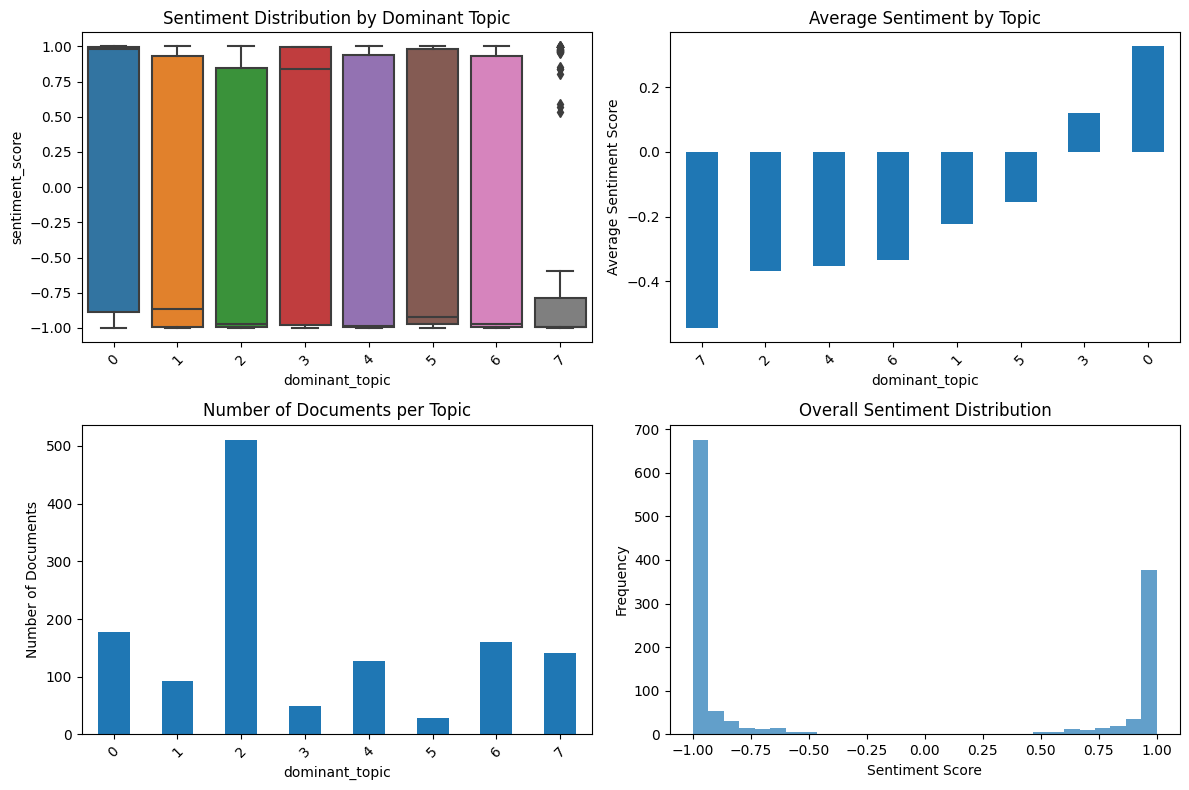


Topic-Sentiment Summary:
Topic 0: Avg Sentiment = 0.327 ± 0.910 (n=177)
Topic 1: Avg Sentiment = -0.223 ± 0.923 (n=93)
Topic 2: Avg Sentiment = -0.369 ± 0.875 (n=511)
Topic 3: Avg Sentiment = 0.120 ± 0.959 (n=50)
Topic 4: Avg Sentiment = -0.352 ± 0.896 (n=128)
Topic 5: Avg Sentiment = -0.156 ± 0.975 (n=29)
Topic 6: Avg Sentiment = -0.335 ± 0.906 (n=161)
Topic 7: Avg Sentiment = -0.544 ± 0.803 (n=141)


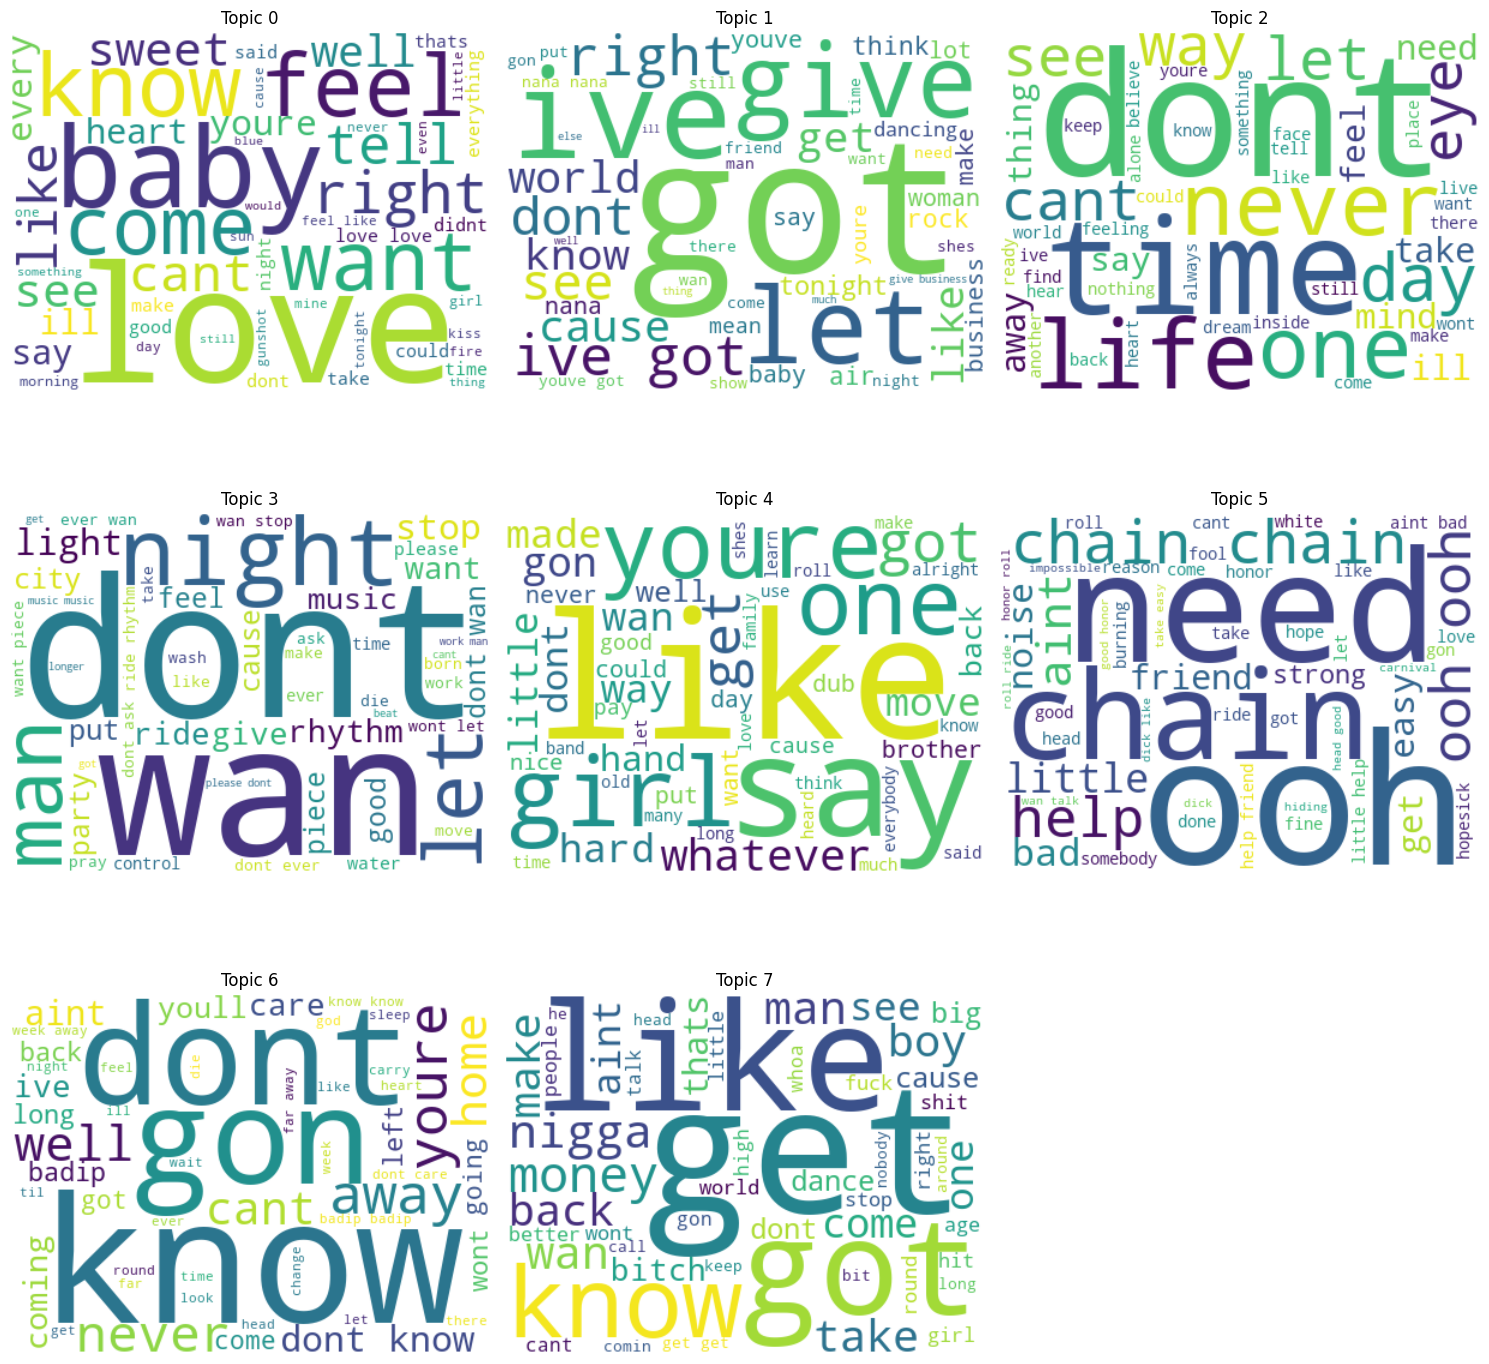

NameError: name 'tokenized_docs' is not defined

In [7]:
if __name__ == "__main__":
    lda_analyzer = LDATopicModeling(df, text_column='clean_lyrics', sentiment_column='sentiment_score')

    lda_model, results_df = lda_analyzer.run_complete_analysis(n_topics=8, max_features=1000)

    # check with coherence scores
    coherence_model = CoherenceModel(model=lda_model, texts=tokenized_docs, dictionary=dictionary, coherence='c_v')
    print("Coherence Score:", coherence_model.get_coherence())
    
    results_df.to_csv('lda_topic_analysis_results_2008.csv', index=False)

    print("\nSample songs per topic:")
    for topic in sorted(results_df['dominant_topic'].unique()):
        topic_songs = results_df[results_df['dominant_topic'] == topic]
        print(f"\nTopic {topic} - Sample songs:")
        sample_songs = topic_songs[['artist', 'title', 'sentiment_score']].head(3)
        print(sample_songs.to_string(index=False))

In [ ]:
# separate by year and month to show changes over time?
# fix labels and titles